# <center> Finding gamma-ray sources into images taken with gamma-ray telecopes </center>

##  <center> Computer Vision and Image Processing M - Exam project </center>

### <center> Antony Zappacosta - Computer Engineering </center>

## Cherenkov Telescope Array (CTA)

The Cherenkov Telescope Array (CTA) is a multinational project to build a new generation of ground-based gamma-ray instrument in the energy range extending from some tens of GeV to about 300 TeV. It is proposed as an open observatory and will consist of two arrays of Imaging Atmospheric Cherenkov telescopes (IACTs), a first array at the Northern Hemisphere with emphasis on the study of extragalactic objects at the lowest possible energies, and a second array at the Southern Hemisphere, which is to cover the full energy range and concentrate on galactic sources.
When gamma rays reach the Earth’s atmosphere they interact with it, producing cascades of subatomic particles which create a flash of “Cherenkov light” (discovered by Russian physicist Pavel Cherenkov in 1934) similar to the sonic boom created by an aircraft exceeding the speed of sound. CTA’s large mirrors and high-speed cameras will detect the flash of light and image the cascade generated by the gamma rays for further study of their cosmic sources.

The following is a CTA Southern Hemisphere Site rendering.

<img src="CTA_array.jpeg" width="612">

CTA will use more than 7000 highly reflective mirror facets (90 cm to 2 m in diameter) to focus light into the telescopes’ cameras. Accordingly, there will be three types of telescopes having three different sizes:

- Small-Sized Telescope (SST): weighing 19 tons and having a primary reflector diameter of 4.3 meters
- Medium-Sized Telescope (MST): weighing 80 tons (SCT) or 82 (MST) tons and having a primary reflector diameter of 9.7 meters (SCT) or 11.5 (MST) meters
- Large-Sized Telescope (LST): weighing 103 tons and having a primary reflector diameter of 23 meters

In the following image we can see, from left to right, the prototype designs of SST, SCT, MST and LST.

<img src="CTA_telescopes_sizes.jpg" width="612">

Once the mirrors reflect the light, the CTA cameras capture and convert it into data. A camera prototype undergoing testing at University of Leicester is showed below.

<img src="CTA_camera_prototype.jpg" width="300">

To maximize the scientific return, the array will send alerts on transients and variable phenomena harnessing the Science Alert Generation (SAG) pipeline, a key system of the CTA Observatory.

Indeed, one of the key applications of Cherenkov Telescope Array is to search for sudden gamma flares, i.e., significant changes in the level of the gamma-ray emission from a known or an unknown source. This gamma-ray transient could last for seconds or days and, in general, they are associated with catastrophic events involving compact objects, such as white dwarves, neutron stars, and black holes, and as such they offer the possibility to study the most extreme physical conditions in the Universe.

The following is a simulation of typical CTA event data represented through the so-called counts map: a representation in which each pixel shows the number of photons that the instrument has detected in that region of the sky. Accordingly, in this case we can observe a gamma flare source being the brightest blob in the image. 
However, the instrument suffers a reconstruction error so that all the photons arriving from a certain position have then to be spread following a Gaussian trend around this position.

<img src="typicalCTAevent.png" width="500">

As we can notice every object in the sky has two coordinates: **right ascension (RA)** and **declination (DEC)**. They are referred to as the object's **celestial coordinates**, where the declination corresponds to latitude and right ascension to longitude.

The other things that can be seen on the map may be the background who does not carry any information and thus has not to be considered.

Each acquired photon is characterized by an observation time, its galactic or celestial coordinates, and its energy (which derives from frequency of the photon itself). **The purpose of our project is to determine whether a source is present in the map and, if this is the case, compute its celestial coordinates**.

## Simulating CTA event data
We simulate CTA events data harnessing **ctools**, a software package developed ad-hoc which can be imported in our python scripts as follows:

In [1]:
import ctools

In simulating CTA events, the functions of ctools require an xml input model (e.g. group1.xml in the directory containing this notebook) which consists 2 of different sections. The first one is the "PointSource section" which includes:

- the parameters of the magnitude of the signal associated with the source (they have been agreed together with INAF and will be fixed for the whole project)
- the position of the source within the skymap (which will vary for each simulation, as we will see later on)

The second section is referred to the magnitude of the bakckground signal: its parameters have been agreed together with INAF and will be fixed for the whole project.

All the source and background photons aggregation phenomena will be varied, as we will see in a while, by the ctobssim function of ctools.

Let's also import all the required libraries we will use in the project.

In [2]:
import os
import matplotlib.pyplot as plt
import astropy.wcs.utils
from astropy.io import fits
from astropy.wcs import WCS
from matplotlib.colors import SymLogNorm, LogNorm
from astropy import units as u
from IPython import display
from lxml import etree
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
import random
import math
import cv2
import numpy as np
import time

We will use the Astropy package to work with "fits" image files produced by CTA events simulation, celestial coordinates objects (SkyCoord) and all its auxiliary functions.

To start simulating CTA events, we harness the ctobssim tool of the ctools package: it generates event list(s) using the instrument characteristics specified by the instrument response function(s) and an input model (the previous described xml file). The simulation includes photon events from astrophysical sources and background events from an instrumental background model.

Thus, we create a wrapper of ctobssim as indicated by INAF:

In [3]:
def run_ctobssim(model, pointing, output, energy=(0.03, 5), time=(0, 100), fov=5, caldb='prod3b-v2', irf='South_z20_0.5h', seed=1):
    sim = ctools.ctobssim()
    sim["inmodel"] = model
    sim["outevents"] = output
    sim["caldb"] = caldb
    sim["irf"] = irf
    sim["ra"] = pointing[0]
    sim["dec"] = pointing[1]
    sim["rad"] = fov
    sim["tmin"] = time[0]
    sim["tmax"] = time[1]
    sim["emin"] = energy[0]
    sim["emax"] = energy[1]
    sim["seed"] = seed
    sim.execute()

We can notice some default parameters in the *run_ctobssim* function: they have been agreed together with INAF and, in particular, some of them specify that our event simulations are associated with:

- A lower energy limit of 0.03 TeV
- An upper energy limit of 5 TeV
- 100 seconds as observation time
- 5 degrees as radius of the field of view
- Instrumental response function being South_z20_0.5h
- Calibration database being prod3b-v2

These parameters, coupled with the ones of the xml input model, will result in much **weaker sources** (in size and brightness) with respect to the example map we looked at in the introduction.

Another crucial input parameter of the ctobssim function is the **seed, whose value will vary for each simulation in order to produce photon events that are always statistically independent from each other (for source photons aggregation phenoma as well as for background events)**.

Now we introduce the function *run_skymap* that wraps the tool ctskymap: it creates a sky map from either a single event list or event lists provided in an observation definition file. The tool will loop over all event lists that are provided and fill all events into a single sky map. Only events within an energy interval spanned by emin and emax are considered.

In [4]:
def run_skymap(obs, output, energy=(0.03, 5), roi=5, caldb='prod3b-v2', irf='South_z20_0.5h', wbin=0.02):
    nbin = int(roi*2/wbin)
    skymap = ctools.ctskymap()
    skymap['inobs'] = obs
    skymap['outmap'] = output
    skymap['irf'] = irf
    skymap['caldb'] = caldb
    skymap['emin'] = energy[0]
    skymap['emax'] = energy[1]
    skymap['usepnt'] = True
    skymap['nxpix'] = nbin
    skymap['nypix'] = nbin
    skymap['binsz'] = wbin
    skymap['bkgsubtract'] = 'IRF'
    skymap.execute()

Let's also define a function to wrap all the operations required for the plot of the counts map, so that we can reuse it multiple times.

In [5]:
def plot_fits_skymap(file, name='skymap.png', title=None, xlabel='right ascension (deg)', ylabel='declination (deg)', figsize=(10, 10), fontsize=20, cmap='magma'):
    # get map
    with fits.open(file) as hdul:
        wcs = WCS(hdul[0].header)
        data = hdul[0].data

    # plot
    fig = plt.figure(figsize=figsize) 
    ax = plt.subplot(projection=wcs)
    img = plt.imshow(data, norm = SymLogNorm(1, vmin = 0), interpolation='gaussian', cmap=cmap)
    ax.coords[0].set_format_unit(u.deg)
    ax.coords[1].set_format_unit(u.deg)
    cb = plt.colorbar(img, ax=ax)
    # axis
    ax.tick_params(axis='both', labelsize=fontsize)
    cb.ax.tick_params(labelsize=fontsize) 
    cb.set_label('counts', fontsize=fontsize)
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.set_title(title, fontsize=fontsize)
    ax.grid(color='grey', ls='solid')
    fig.tight_layout()
    fig.savefig(name)
    return

We use the defined functions to generate a map with a randomly positioned gamma-ray source. 

Firstly, we create a directory in which to store all the data that will be generated.

In [6]:
if not os.path.isdir('data'):
    os.mkdir('data')

We define the pointing of the map (centre of field of view) through its celestial coordinates (RA, DEC).

In [7]:
pointing = (83.6331, 22.5145)
pointing_skycoords = SkyCoord(pointing[0], pointing[1], frame='icrs', unit='deg')

As we can see, it is possible to create a SkyCoord object harnessing its constructor provided by the Astropy library. This will be essential for using some analysis functions that we will need during the project.

We now write a function that, given the pointing and the maximum distance from it, generates two random celestial coordinates picked in the circle having centre equal to the pointing and radius equal to the maximum distance from it. In this case we set the maximum angular distance from the pointing to 3.5 degrees in order to better work with the effective area of the telescope. Indeed, during tests we noticed that approaching the edges of the field-of-view, there is a drastic drop in the effective area of the telescope and it means that far fewer photons are collected at the edges than at the centre. Accordingly, also if there is a source, the telescope could not sees it or sees it very badly.

In [8]:
def generate_ra_dec(pointing, radius = 3.5):
    a = random.random()
    b = random.random()
    x = radius * math.sqrt(a) * math.cos(2 * math.pi * b)
    y = radius * math.sqrt(a) * math.sin(2 * math.pi * b)
    RA = x + pointing[0]
    DEC = y + pointing[1]
    RA = round(RA, 4)
    DEC = round(DEC, 4)
    return (RA, DEC)

For this starting section, we fix the skycoordinates of a source. We will use the above defined function later on.

In [9]:
#RA, DEC = generate_ra_dec(pointing)
RA, DEC = 84.9732, 23.6372
random_skycoords = SkyCoord(RA, DEC, frame='icrs', unit='deg')
print(random_skycoords)

<SkyCoord (ICRS): (ra, dec) in deg
    (84.9732, 23.6372)>


Once we have the random positioned source, we need to write its coordinates (RA, DEC) inside the input model (xml file) for the ctobssim tool. For this purpose we use the etree object of the lxml library.

In [10]:
tree = etree.parse('group1.xml')
root = tree.getroot()

root[0][1][0].set('value',str(RA)) #set of RA in the xml
root[0][1][1].set('value',str(DEC)) #set of DEC in the xml
tree.write('group1.xml', standalone=False) #write back to file

Thus, we are ready to generate the map.

Set MJD-END to 51544.000000 from DATE-END'. [astropy.wcs.wcs]


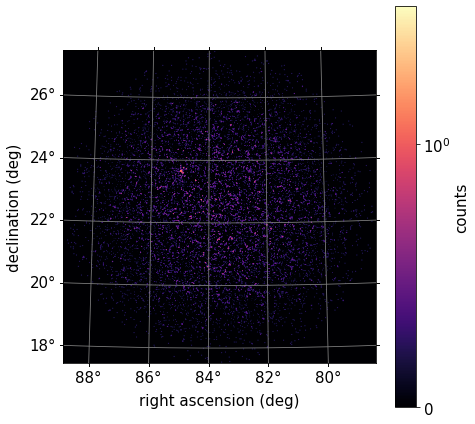

In [11]:
model_map = 'group1.xml'
skymap = 'data/sim.fits'
run_ctobssim(model=model_map, pointing=pointing, output=skymap)
run_skymap(obs=skymap, output=skymap)
plot_fits_skymap(file=skymap, name='data/sim.png', figsize=(6, 6), fontsize=15)

We can hardly notice the presence of the source and where it is located. It is the small flare at coordinates:

In [12]:
print("Right ascension = ", RA, "; Declination = ", DEC, ".")

Right ascension =  84.9732 ; Declination =  23.6372 .


Let's also generate a map referred to an input model which describes background only (without any real gamma-ray source)

Set MJD-END to 51544.000000 from DATE-END'. [astropy.wcs.wcs]


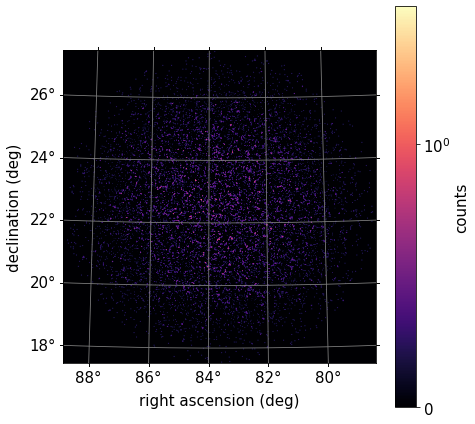

In [13]:
model_map_bkg = 'bkg_irf.xml'
skymap_bkg = 'data/sim_bkg.fits'
run_ctobssim(model=model_map_bkg, pointing=pointing, output=skymap_bkg)
run_skymap(obs=skymap_bkg, output=skymap_bkg)
plot_fits_skymap(file=skymap_bkg, name='data/sim_bkg.png', figsize=(6, 6), fontsize=15)

And let's look at the corresponding histograms of the two maps and their maximum intensities.

Histogram of the map with a source:


Set MJD-END to 51544.000000 from DATE-END'. [astropy.wcs.wcs]


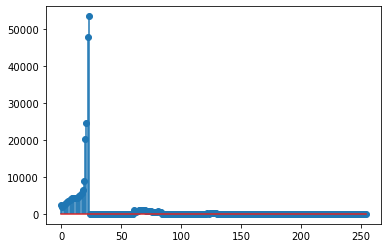

Set MJD-END to 51544.000000 from DATE-END'. [astropy.wcs.wcs]


Maximum intensity in the map:  3.8041339830220817




Histogram of the map with background only


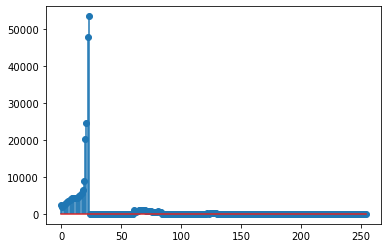

Maximum intensity in the background map:  3.8041339830220817


In [14]:
with fits.open(skymap) as hdul:
            wcs = WCS(hdul[0].header)
            data = hdul[0].data

print("Histogram of the map with a source:")
hist,bins = np.histogram(data.flatten(),255)
plt.stem(hist, use_line_collection=True)
plt.show()
print("Maximum intensity in the map: ", np.max(data))

with fits.open(skymap_bkg) as hdul_bkg:
            wcs_bkg = WCS(hdul_bkg[0].header)
            data_bkg = hdul_bkg[0].data

print("\n\n\n")
print("Histogram of the map with background only")
hist_bkg,bins_bkg = np.histogram(data_bkg.flatten(),255)
plt.stem(hist_bkg, use_line_collection=True)
plt.show()
print("Maximum intensity in the background map: ", np.max(data_bkg))

Hence, we are not allowed to distinguish whether there is one source or not in the map just considering its maximum intensity or the differences between its histogram and the one related to the background-only map.

We are now going to build a solution to the proposed issue which will then be exteded to the case in which more than one source is present within the image and, accordingly, we will discuss its limits. Ultimately we will simplify the model taking into account more visible sources to explore one more problem related to the overlapping situations that may occur when an high number of strong sources have to be detected.

## Analysis method

Since a "fits" image has only one channel, we are going to process it as it is a grayscale image: for each pixel there is a single intensity value.

In [15]:
print(data.shape)

(500, 500)


We start by increasing the intensity of all pixels in the map (gain factor = 10), to then apply a gaussian filter having σ = 3 in order to:

- smooth the image and highlight a larger and more visible structure inside it (the gamma-ray source)
- represent the error suffered by the instrument in seeing a punctual source (Point Spread Function)

For instance, if we wouldn't have previously multiplied the intensities in the image by a gain factor, applying the gaussian filter would had led us to an excessive loss of information.

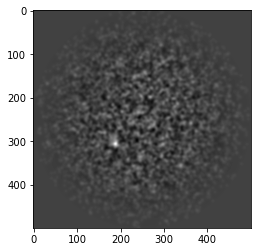

In [16]:
higher_intensities = data * 10
sigma = 3
k_size = int(np.ceil((3*sigma))*2 + 1) #rule of thumb for a good kernel size given sigma
img_G = cv2.GaussianBlur(higher_intensities, (k_size,k_size) , sigma)

plt.imshow(img_G,cmap='gray')
plt.show()

We can notice that by plotting the simulated phenomena in pixel coordinates through the *imshow* function of matplotlib, they look reversed with respect to the horizontal axis (in comparison with the first seen skymap). This is due to the projection of the image being different from the one of the fits skymap. However, what described is not relevant for the purposes of our analysis, as the conversion from celestial coordinates to pixel coordinates keeps unchanged.

The source is now more visible but the image features a small gray-level range, which results in poor contrast. We can thus perform a linear contrast stretching (with s_min = 0 and s_max equal to the maximum intensity of the image) to enhance the difference between the source and the background.

In [17]:
def linear_contrast_stretching(img, max_value, min_value):
    img[img<min_value] = min_value
    img[img>max_value] = max_value
    linear_stretched_img = 255./(max_value-min_value)*(img-min_value)
    return linear_stretched_img

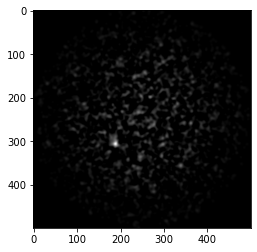

In [18]:
img_stretched = linear_contrast_stretching(img_G, np.max(img_G), 0)
plt.imshow(img_stretched,cmap='gray')
plt.show()

Let's now binarize the image so that all the pixels having an intensity value above 150 will be set to 255; all the other pixels' intensities will be set to zero.

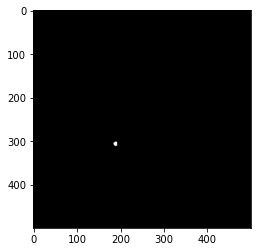

In [19]:
#We cast the image to uint8, for working with cv2.connectedComponentsWithStats
int_str = np.copy(img_stretched)
int_str = int_str.astype(np.uint8)

ret, thresh = cv2.threshold(int_str, 150, 255, cv2.THRESH_BINARY)
plt.imshow(thresh,cmap='gray')
plt.show()

Up to this point we can compute the connected components in the image and retrieve the area and the position of each of them.

In [20]:
connectivity = 4
output = cv2.connectedComponentsWithStats(thresh, connectivity, cv2.CV_32S)
num_labels = output[0]
stats = output[2]
stats = stats[1:] #we exclude the image itself
centroids = output[3]
centroids = centroids[1:] #we exclude the image itself

print("Connected components:")
print("{leftmost (x) coordinate, topmost (y) coordinate, width of the bounding box, height of the bounding box, area}")
print(stats)

Connected components:
{leftmost (x) coordinate, topmost (y) coordinate, width of the bounding box, height of the bounding box, area}
[[184 301   9  11  69]]


Let's do the same processing for the image containing background only

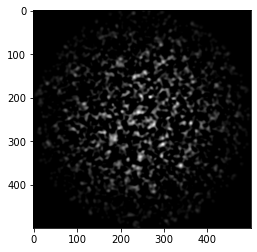

In [21]:
higher_intensities_bkg = data_bkg * 10                                            #scale-up intensities
img_G_bkg = cv2.GaussianBlur(higher_intensities_bkg, (k_size,k_size) , sigma)     #guassian filter σ = 3
img_stretched_bkg = linear_contrast_stretching(img_G_bkg, np.max(img_G_bkg), 0)   #linear contrast stretching
plt.imshow(img_stretched_bkg,cmap='gray')
plt.show()

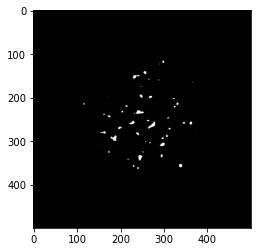

Connected components:
[[296 116   5   5  19]
 [290 123   1   2   2]
 [253 140   7   7  35]
 [229 149  15   8  64]
 [265 157   2   3   5]
 [288 159   2   3   4]
 [366 164   1   2   2]
 [247 174   2   2   3]
 [245 194   6   8  34]
 [266 197   7   5  30]
 [173 199   1   1   1]
 [321 202   4   2   8]
 [329 212   5   6  21]
 [115 214   4   3   9]
 [212 218   5   4  15]
 [323 220   4   4  12]
 [203 231   4   4  14]
 [236 230  18   8  95]
 [232 236   2   2   4]
 [161 238   4   3   9]
 [171 242   7   4  22]
 [308 246   4   3  10]
 [261 252   6   3  14]
 [221 254  12   8  54]
 [264 256  16  16 106]
 [344 256   5   5  17]
 [359 256   6   7  32]
 [195 267   8   6  30]
 [311 270   5   4  15]
 [374 277   1   1   1]
 [154 278  13   6  36]
 [236 281   7   6  30]
 [305 286   4   5  17]
 [178 288  14  12  99]
 [295 292   5   4  17]
 [257 301   2   2   4]
 [267 303   3   3   7]
 [291 304  11   8  61]
 [149 310   1   1   1]
 [172 324   4   3  11]
 [251 324   2   3   6]
 [293 331   5   7  26]
 [242 333   

In [22]:
int_str_bkg = np.copy(img_stretched_bkg)
int_str_bkg = int_str_bkg.astype(np.uint8)

ret_bkg, thresh_bkg = cv2.threshold(int_str_bkg, 150, 255, cv2.THRESH_BINARY)
plt.imshow(thresh_bkg,cmap='gray')
plt.show()

output_bkg = cv2.connectedComponentsWithStats(thresh_bkg, connectivity, cv2.CV_32S)
num_labels_bkg = output_bkg[0]
stats_bkg = output_bkg[2]
stats_bkg = stats_bkg[1:] #we exclude the image itself
centroids_bkg = output_bkg[3]
centroids_bkg = centroids_bkg[1:] #we exclude the image itself

print("Connected components:")
print(stats_bkg)

As a rule, assessing if there is only one connected component within the binarized map is not a robust solution for determining wheter a source is present or not in the image. The main reason is that when the sources are weaker (i.e. they have fewer photon counts in the map) we observe more blobs around the highest intensities of the stretched image (and, therefore, in the binarized one).

Let us now consider a new histogram of the linearly stretched image containg the source, in which we cut the zero-closest values (the first one hundred intensities).

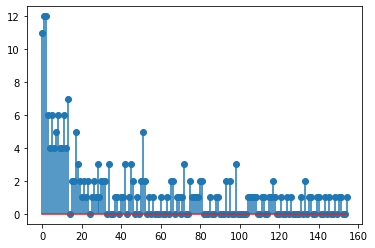

Maximum value of the histogram without the first 100 intensities:  12


In [23]:
hist,bins = np.histogram(img_stretched.flatten(),255)
cutted_hist = hist[100:255]
plt.stem(cutted_hist, use_line_collection=True)
plt.show()

max_hist = np.max(cutted_hist)
print("Maximum value of the histogram without the first 100 intensities: ", max_hist)

And let's compute the same data for the image with background only.

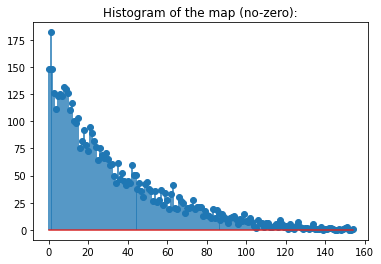

Here, we can see that the maximum value of the histogram without the first 100 intensities is  182


In [24]:
hist_bkg,bins_bkg = np.histogram(img_stretched_bkg.flatten(),255)
cutted_hist_bkg = hist_bkg[100:255]

plt.title("Histogram of the map (no-zero):")
plt.stem(cutted_hist_bkg, use_line_collection=True)
plt.show()

max_hist_bkg = np.max(cutted_hist_bkg)

print("Here, we can see that the maximum value of the histogram without the first 100 intensities is ", max_hist_bkg)

As we will see in the result section, detecting the presence or the absence of a source in the map through thresholding the maximum of this histogram and analyzing the area of the blobs into the map and their distance from the pointing offers reasonable results.

In [25]:
def check_for_source(num_labels, centroids, stats, int_str, max_hist):
    maxBlobOutOfThree = None
    maxAreaOutOfThree = 0

    maxBlobBetTwoAndThree = None
    maxAreaBetTwoAndThree = 0

    if (num_labels - 1) > 0:
        for label in range(0, (num_labels-1)):
            candidate = astropy.wcs.utils.pixel_to_skycoord(centroids[label][0], centroids[label][1], wcs)
            distCandidate = candidate.separation(pointing_skycoords).deg
            areaCandidate = stats[label][4]
            if distCandidate > 2 and distCandidate <= 3 and areaCandidate > maxAreaBetTwoAndThree:
                maxAreaBetTwoAndThree = areaCandidate
                maxBlobBetTwoAndThree = candidate
            elif distCandidate > 3 and areaCandidateOutOfThree > maxAreaOutOfThree:
                maxAreaOutOfThree = areaCandidate
                maxBlobOutOfThree = candidate

    identified_source = None
    
    if max_hist < 65:
        (minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(int_str)
        identified_source = astropy.wcs.utils.pixel_to_skycoord(maxLoc[0], maxLoc[1], wcs)
    elif maxAreaBetTwoAndThree > 100 and max_hist < 140:
        identified_source = maxBlobBetTwoAndThree
    elif maxAreaOutOfThree > 48 and max_hist < 140:
        identified_source = maxBlobOutOfThree
    return identified_source

As we can see in the above defined function, we classify as a source only a blob that shows at least one of the following properties:

- Containing the brightest point in a map for which the cropped histogram has a maximum value below 65
- Being distant from the pointing at least 2 degrees and up to 3 degrees, having an area which is higher than 100 and belonging to a map for which the cropped histogram has a maximum value below 140
- Being distant from the pointing at least 3 degrees, having an area which is higher than 48 and belonging to a map for which the cropped histogram has a maximum value below 140

These parameters were obtained through experimental approaches, evaluating the averages and the median values of both histogram peaks and area of the blobs for sources and background items according to their distance from the pointing.

Some alternatives to the proposed classification method has been analyzed:

- study also the area for blobs residing at most 2 degrees away from pointing rather than searching for the brightest spot
- computing and thresholding the intensities variance of the image rather than thresholding the maximum of the cut histogram

However, these approaches have shown worse results than the adopted method.

In [26]:
identified_source = check_for_source(num_labels, centroids, stats, int_str, max_hist)
if identified_source is not None:
    print(identified_source)
else:
    print("No source in the image")

<SkyCoord (ICRS): (ra, dec) in deg
    (84.95369442, 23.63916059)>


In order to measure the performances of the described algorithm we will use the angular distance between the identified source and the random generated one (aka, measurement error), computed through the Astropy separation method.

In [27]:
if identified_source is not None:
    error = identified_source.separation(random_skycoords).deg
    print("Angular distance between the identified source and the random generated one [DEG]:")
    print(error)

Angular distance between the identified source and the random generated one [DEG]:
0.017976210696042542


For the sake of completeness, we show the same analysis performed on the background image.

In [28]:
identified_source = check_for_source(num_labels_bkg, centroids_bkg, stats_bkg, int_str_bkg, max_hist_bkg)
if identified_source is not None:
    print(identified_source)
else:
    print("No source in the image")

No source in the image


### Results of the analysis method

Defining as:

*d := angular distance between the identified source and the corresponding random generated source (aka, measurement error)*

*True positives (tp) := the number of times we identified a source having d < 0.1 deg*

*False positives (fp) := the number of times we identified a source having d >= 0.1 deg*

*False negatives (fn) := the number of times a source was not identified (i.e. the image was classified as background only)*

*True negatives (fn) := the number of times a background-only skymap was correctly classified as such*

Tests with 1000 different images in which half of them contained a random generated gamma-ray source and the other 500 images consisted of background only maps showed the following results:

*tp = 456, fp = 27, fn = 44, tn = 487*

Thus the *precision* and *recall* are:

* $Precision = tp / (tp + fp) = 0.94$
* $Recall = tp / (tp + fn) = 0.91$

While tests with 1000 different images in which every map had a random generated gamma-ray source showed the following results:

*tp = 868, fp = 16, fn = 132*

Thus the *precision* and *recall* are:

* $Precision = tp / (tp + fp) = 0.98$
* $Recall = tp / (tp + fn) = 0.87$

## Extension to multiple sources (optional)

This time we build an etree object on an xml model which can contain 2 sources (here 'group1_2sources.xml').

In [29]:
tree = etree.parse('group1_2sources.xml')
root = tree.getroot()

And we generate two random couples of coordinates for two distinct flares.

Set MJD-END to 51544.000000 from DATE-END'. [astropy.wcs.wcs]


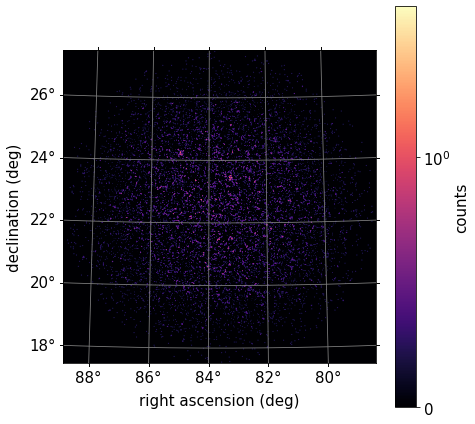

In [30]:
RA1, DEC1 = generate_ra_dec(pointing, radius = 3.5)
random_skycoords1 = SkyCoord(RA1, DEC1, frame='icrs', unit='deg')

RA2, DEC2 = generate_ra_dec(pointing, radius = 3.5)
random_skycoords2 = SkyCoord(RA2, DEC2, frame='icrs', unit='deg')

random_skycoords_list = []
random_skycoords_list.append(random_skycoords1)
random_skycoords_list.append(random_skycoords2)

root[0][1][0].set('value',str(RA1)) #set of RA of source 1 in the xml
root[0][1][1].set('value',str(DEC1)) #set of DEC of source 1 in the xml

root[1][1][0].set('value',str(RA2)) #set of RA of source 2 in the xml
root[1][1][1].set('value',str(DEC2)) #set of DEC of source 2 in the xml

###### WRITE ALL TO XML MODEL ######
tree.write('group1_2sources.xml', standalone=False)

model_map_2 = 'group1_2sources.xml'
skymap_2 = 'data/sim_2.fits'
run_ctobssim(model=model_map_2, pointing=pointing, output=skymap_2)
run_skymap(obs=skymap_2, output=skymap_2)
plot_fits_skymap(file=skymap_2, name=skymap_2.replace('.fits', '.png'), figsize=(6, 6), fontsize=15)

Comment: it could happen that, by generating two random gamma-ray sources, one (or also both) of them could be very dim and the telescope simulation could not sees it at all. In these cases, just run again the last cell.

In [31]:
print("Random generated Skycoords:")
for s in random_skycoords_list:
    print(s)

Random generated Skycoords:
<SkyCoord (ICRS): (ra, dec) in deg
    (84.9971, 24.1803)>
<SkyCoord (ICRS): (ra, dec) in deg
    (83.2594, 23.4307)>


Thus we repeat the same image processing who has been done for the model with one source only.

Set MJD-END to 51544.000000 from DATE-END'. [astropy.wcs.wcs]


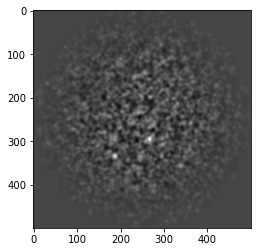

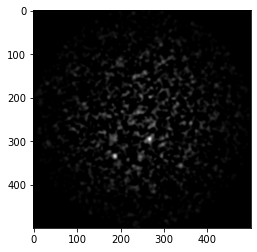

In [32]:
with fits.open(skymap_2) as hdul:
        wcs = WCS(hdul[0].header)
        data = hdul[0].data

higher_intensities = data * 10

#Smoothing by a Gaussian filter
sigma = 3
k_size = int(np.ceil((3*sigma))*2 + 1)
img_G = cv2.GaussianBlur(higher_intensities, (k_size,k_size) , sigma)
plt.imshow(img_G,cmap='gray')
plt.show()

#Linear contrast stretching
img_stretched = linear_contrast_stretching(img_G, np.max(img_G), 0)
plt.imshow(img_stretched,cmap='gray')
plt.show()

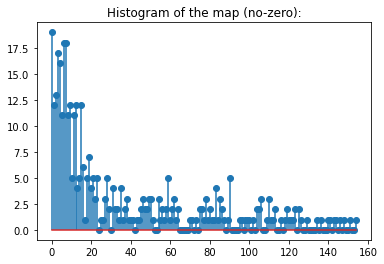

Maximum of the histogram:  19


In [33]:
hist,bins = np.histogram(img_stretched.flatten(),255)
cutted_hist = hist[100:255]

plt.title("Histogram of the map (no-zero):")
plt.stem(cutted_hist, use_line_collection=True)
plt.show()

max_hist = np.max(cutted_hist)
print("Maximum of the histogram: ", max_hist)

In the one-source case, when the cut histogram maxima was lower than 65, we have searched for the brightest point in the map. However, trying to build a solution approaching the scalability to an arbitrary number of sources, we got rid of the searching for the brightest spot in the map and replaced it by carrying out a surface-based classification also for connected components that reside in the first two degrees of distance from the pointing. 

Furthermore, in working with multiple sources we noticed a decrease of both the average area of source blobs and the average peak of the cropped histogram. Thus we lowered the histogram threshold and the minimum area that a blob must assume to be considered as a source: **each** blob within the binarized skymap is detected as a gamma-ray source if it shows at least one of the following properties:

- Being distant from the pointing at most 2 degrees, having an area which is higher than 38 and belonging to a map for which the cropped histogram has a maximum value below 65

- Being distant from the pointing at least 2 degrees and up to 3 degrees, having an area which is higher than 29 and belonging to a map for which the cropped histogram has a maximum value below 110

- Being distant from the pointing at least 3 degrees, having an area which is higher than 24 and belonging to a map for which the cropped histogram has a maximum value below 110

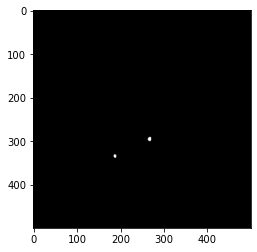

Identified a source:
<SkyCoord (ICRS): (ra, dec) in deg
    (83.25205565, 23.43138811)>
Identified a source:
<SkyCoord (ICRS): (ra, dec) in deg
    (84.99073901, 24.20766074)>


In [34]:
def check_for_sources(num_labels, centroids, stats, int_str, max_hist):
    
    results = []

    if (num_labels - 1) > 0:
        for label in range(0, (num_labels-1)):
            candidate = astropy.wcs.utils.pixel_to_skycoord(centroids[label][0], centroids[label][1], wcs)
            distCandidate = candidate.separation(pointing_skycoords).deg
            areaCandidate = stats[label][4]
            if distCandidate <= 2 and max_hist < 65 and areaCandidate > 38:
                identified_source = candidate
                results.append(identified_source)
            if distCandidate > 2 and distCandidate <= 3 and areaCandidate > 29 and max_hist < 110:
                identified_source = candidate
                results.append(identified_source)
            elif distCandidate > 3 and areaCandidateOutOfThree > 24 and max_hist < 110:
                identified_source = candidate
                results.append(identified_source)

    if len(results) == 0:
        print("No source in the image")
    else:
        #error = identified_source.separation(random_skycoords).deg
        for identified_source in results:
            print("Identified a source:")
            print(identified_source)

    return results
            
int_str = np.copy(img_stretched)
int_str = int_str.astype(np.uint8)

# all pixels value above 150 will be set to 255
ret, thresh = cv2.threshold(int_str, 150, 255, cv2.THRESH_BINARY)
plt.imshow(thresh,cmap='gray')
plt.show()

connectivity = 4
output = cv2.connectedComponentsWithStats(thresh, connectivity, cv2.CV_32S)
num_labels = output[0]
stats = output[2]
stats = stats[1:] #we exclude the image itself
centroids = output[3]
centroids = centroids[1:] #we exclude the image itself

results = check_for_sources(num_labels, centroids, stats, int_str, max_hist)

In order to measure the performances of the described method we define a function that takes as input an identified source and the list of random generated sources and computes the nearest matching between them minimizing the separation method of astropy. Thus the function returns an error (in DEG) and a new list where the matched random source has been removed. The utility of this funciton is for computing the measurament error only.

In [35]:
def match_source_with_random(identified_source, rand_srcs):
    min_index = 0
    error = identified_source.separation(rand_srcs[0]).deg
    for idx in range(1, len(rand_srcs)):
        temp_err = identified_source.separation(rand_srcs[idx]).deg
        if temp_err < error:
            min_index = idx
            error = temp_err
    if error < 0.1: #if the source is found (error < 0.1) I delete the corresponding random generated source
        new_list = np.delete(rand_srcs, min_index)
        return (error, new_list)
    else: #else I return the same input list of random generated sources
        return (error, rand_srcs)

In [36]:
for source in results:
    error, random_skycoords_list = match_source_with_random(source, random_skycoords_list)
    print(error)

0.006773770041605563
0.027969202549731873


### Results of the analysis method - extension to multiple sources

Defining as:

*d := angular distance between the identified source and the corresponding random positioned source (aka, measurement error)*

*True positives (tp) := the number of times we identified a source having d < 0.1 deg*

*False positives (fp) := the number of times we identified a source having d >= 0.1 deg for each random source we have generated*

*False negatives (fn) := the number of times a random source was not identified (i.e. the image was classified as background only or one of the generated sources has not been found in the image)*

*True negatives (fn) := the number of times a background-only skymap was correctly classified as such*

#### Performances with 2 sources

Tests with 1000 different images in which half of them contained **two** random generated gamma-ray sources and the other 500 images consisted of background only maps showed the following results:

*tp = 701, fp = 118, fn = 299, tn = 429*

Thus the *precision* and *recall* are:

* $Precision = tp / (tp + fp) = 0.85$
* $Recall = tp / (tp + fn) = 0.70$

While tests with 1000 different images in which every map had **two** random generated gamma-ray sources showed the following results:

*tp = 1386, fp = 20, fn = 614*

Thus the *precision* and *recall* are:

* $Precision = tp / (tp + fp) = 0.98$
* $Recall = tp / (tp + fn) = 0.69$

In general, the performances of the algorithm decreases as the number of sources to be recognized gets high. The main reason is to be found in the fluctuation of the classification parameters of a source (area, histogram peak) when the number of flares changes. Consequently, the search for a more suitable analysis method to face the presence of an arbitrary number of weak sources is postponed to future developments.

### Further developments

In one phase of the project we tried to analyze the performances of the described method in a scenario where sources were very strong (Crab model). 

<img src="typicalCTAevent.png" width="500">

In this case, excellent results were obtained in the multi-source scenario: precision and recall were almost always over 0.95 for a number of sources ranging from 1 to 5. Indeed, the stronger are the flares, the easier is to detect them just analyzing their area (histogram peak-based classification was not needed to asses the presence or the absence of a source in the skymap).

Indeed, in classifying as sources only those blobs having an higher surface than a certain threshold in the binarized skymap, the following results were obtained:

*p := precision*

*r := recall*

| n. of sources| Results of tests with 1000 images |
| :---         |              :----:               |
| 1 source     | p = 0.98, r = 1.00                |
| 2 sources    | p = 0.99, r = 0.98                |
| 3 sources    | p = 0.99, r = 0.95                |
| 5 sources    | p = 0.98, r = 0.86                |
| 10 sources   | p = 0.96, r = 0.62                |

However, we want to highlight a situation in which even dealing with stronger sources can lead to some issues: we can notice that the recall performance metric starts to decline when the number of sources gets high (e.g. 10).

Accordingly, we observed that the probability of overlapping between different blobs significantly increases as the number of sources do so: this can lead to identify multiple flares as a single source, dropping the number of relevant items that were retrieved.

Binarized image of 10 sources in which two of them are slightly overlapping:

<img src="slight_overlap.png" width="500">

Binarized image of 10 sources that sharply overlap (4 sources are strongly overlapping):

<img src="sharp_overlap.png" width="500">

Recognition of the slight overlapping situations led us to try some improvement by eroding the binarized image before computing the connected components inside the skymap. Accordingly, we find out better results for the recall performance metric for cases with a high number of sources in the image: more relevant items were retrieved. On the other hand, for cases with few sources, performances have stayed almost unchanged.

Let us briefly consider 10 strong sources gerated through the crab input model:

Set MJD-END to 51544.000000 from DATE-END'. [astropy.wcs.wcs]


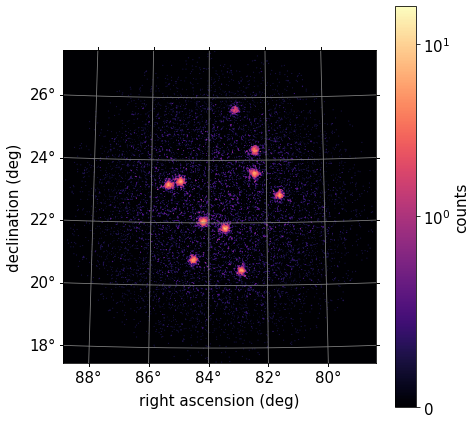

In [37]:
model_input = 'crab10sources.xml'
tree = etree.parse(model_input)
root = tree.getroot()

RA = [84.5184, 81.5545, 85.3898, 82.3958, 82.8839, 82.4167, 84.9904, 84.1877, 83.4378]
DEC = [20.7998, 22.878, 23.1941, 24.2978, 20.4689, 23.5647, 23.3078, 22.0348, 21.8127]

for i in range(0, 9):
    random_skycoords = SkyCoord(RA, DEC, frame='icrs', unit='deg')
    root[i][1][0].set('value',str(RA[i]))
    root[i][1][1].set('value',str(DEC[i]))

tree.write(model_input, standalone=False)
skymap_10 = 'data/sim_10.fits'
run_ctobssim(model=model_input, pointing=pointing, output=skymap_10)
run_skymap(obs=skymap_10, output=skymap_10)
plot_fits_skymap(file=skymap_10, name=skymap_10.replace('.fits', '.png'), figsize=(6, 6), fontsize=15)

And let's binarize the image.

Set MJD-END to 51544.000000 from DATE-END'. [astropy.wcs.wcs]


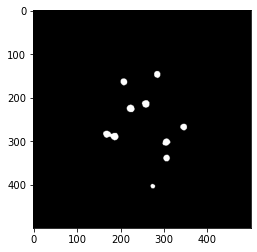

In [38]:
with fits.open(skymap_10) as hdul:
            wcs = WCS(hdul[0].header)
            data = hdul[0].data

higher_intensities = data * 10

#Smoothing by a Gaussian filter
sigma = 3
k_size = int(np.ceil((3*sigma))*2 + 1)
img_G = cv2.GaussianBlur(higher_intensities, (k_size,k_size) , sigma)
g_copy = np.copy(img_G)
g_copy = g_copy.astype(np.uint8)

#Linear contrast stretching
img_stretched = linear_contrast_stretching(img_G, np.max(img_G), 0)

int_str = np.copy(img_stretched)
int_str = int_str.astype(np.uint8)

# all pixels value above 50 will be set to 255 (in the stronger source case, we just need a smaller threshold)
ret, thresh1 = cv2.threshold(int_str, 50, 255, cv2.THRESH_BINARY)
plt.imshow(thresh1,cmap='gray')
plt.show()

Hence, let us now erode the binarized map by a 3x3 circular structuring element (5 iterations) through the cv2.erode function.

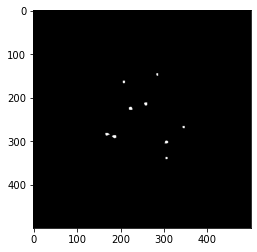

In [39]:
#Example of erosion by a 3x3 circular structuring element of the last processed map
kernelSize = (3, 3)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernelSize)
eroded = cv2.erode(thresh1.copy(), kernel, iterations=5)
plt.imshow(eroded,cmap='gray')
plt.show()

Tests with 1000 different images of maps having **ten** random generated gamma-ray sources showed the following results when the binarized image is eroded by a 3x3 circular structuring element for 5 iterations:

*tp = 8078, fp = 501, fn = 1922*

Thus the *precision* and *recall* are:

* $Precision = tp / (tp + fp) = 0.94$
* $Recall = tp / (tp + fn) = 0.80$

There was an 18% improvement in the recall performance metric.
These improvements are, however, limited by the side effect given by erosion which in such cases can make the smallest sources disappear (as we can notice in the last example map above), leading to an increment of false negatives. For this reason (and, in general), to obtain even better performances with an arbitrary number of sources, refined methods could be studied to choose the number of erosion iterations to be applied and understand after how many of them we would compute the connected components inside the binarized image.